In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from Helpers.header import *

Defaulting to user installation because normal site-packages is not writeable


In [2]:


# all the formulas are from https://cs.nyu.edu/~roweis/papers/sne_final.pdf
# and http://www.cs.toronto.edu/~hinton/absps/tsne.pdf
PERPLEXITY=5
g_kernel=1
EPOCHS=2000
LR=200
MOMENTUM=0.99

def getKey(item):
    return item[1]

In [3]:

#compute the distance between the neighboors of x1 and return a list of the k neghboors
#where k is the complexity
def k_neighbours(x,x1_index,p_or_q='p'):
    x1=x[x1_index]
    list_k_neighbours=[]
    for i in range(x.shape[0]):
        if i!=x1_index:
            xi=x[i]
            if p_or_q=='p':
                distance=np.exp(-np.linalg.norm(x1-xi)**2/(2*g_kernel**2))
            else:
                distance=(1+np.linalg.norm(x1-xi)**2)**-1
            list_k_neighbours.append([i,distance])
    
    list_k_neighbours=sorted(list_k_neighbours,key=getKey)
    return list_k_neighbours[:PERPLEXITY]

In [4]:

#compute the similarity pij between two xi,xj in the original space
#divide the distance between xi,xj by the sum of the distances of the k_neightbours where k is the complexity
def compute_pij(x,x1_index,x2_index):
    x1=x[x1_index]
    x2=x[x2_index]
    # num=(1+np.linalg.norm(x1-x2)**2)**(-1)/(2*g_kernel**2))
    num=np.exp(-np.linalg.norm(x1-x2)**2)/(2*g_kernel**2)
    denom=0
    list_k_neighbours=k_neighbours(x,x1_index,'p')
    for i in list_k_neighbours:
        denom+=i[1]
    return num/denom

In [5]:

#compute the table p of the xij in the original space
def compute_p(x):
    table=np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if i!=j:
                pij=compute_pij(x,i,j)
                pji=compute_pij(x,j,i)
                table[i,j]=(pij+pji)/(2*x.shape[0])
                # table[i,j]=pij
    return table

In [6]:

#compute the similarity qij between two yi,yj in the new space
#divide the distance between yi,yj by the sum of the distances of the k_neightbours where k is the complexity
def compute_qij(y,y1_index,y2_index):
    y1=y[y1_index]
    y2=y[y2_index]
    num=(1+np.linalg.norm(y1-y2)**2)**(-1)
    denom=0
    for i in k_neighbours(y,y1_index,'q'):
        denom+=i[1]
    return num/denom

In [7]:

#compute the table q of the yij in the new space
def compute_q(y):
    table=np.zeros((y.shape[0],y.shape[0]))
    for i in range(y.shape[0]):
        for j in range(y.shape[0]):
            if i!=j:
                qij=compute_qij(y,i,j)
                table[i,j]=qij
    return table

In [8]:

#compute the erros between the 2 distributions using the KL-divergence
def kl_divergence(p,q):
    total=0
    for i in range(p.shape[0]):
        for j in range(q.shape[0]):
            if q[i,j]!=0 and p[i,j]!=0:
                total+=p[i,j]*np.log(p[i,j]/q[i,j])
    return total

In [9]:

#apply gradient descent to lower the KL-divergence
#added momentum increase the speed
def gradient_descent(p,q,y):
    history=np.zeros((p.shape[0],2,y.shape[1]))
    for iter in range(EPOCHS):
        for i in range(y.shape[0]):
            sum_value=0
            for j in range(y.shape[0]):
                sum_value+=((y[i]-y[j])*(p[i,j]-q[i,j])*(1+np.linalg.norm(y[i]-y[j]**2))**-1)
            y[i]-=4*LR*sum_value+MOMENTUM*(history[i,1]-history[i,0])
            history[i,0]=history[i,1]
            history[i,1]=y[i]
        if iter%100==0:
            q=compute_q(y)
            print(kl_divergence(p,q)) 
    y-=np.mean(y)
    y/=np.std(y)
    return y

(10000, 784)
(20, 784)


<ipython-input-4-a3bfa76c3c7c>:12: RuntimeWarning: invalid value encountered in double_scalars
  return num/denom


[[ 9257.10877465  9037.25626382]
 [14497.72845834 14084.25551851]
 [ 5295.7196791   4676.21026249]
 [16943.57295954 18659.92022884]
 [ 7762.0465908   9723.48850145]
 [ 7235.35636686  6266.28205886]
 [10098.24719854 10085.24087768]
 [ 9910.2326507   9990.62065625]
 [13620.49338572 15412.96990047]
 [15055.63064775 15399.25381422]
 [14621.04875156 14796.1762606 ]
 [13294.57381081 13970.89374282]
 [10616.07626622 11643.66437463]
 [13184.87168593 14700.41166681]
 [ 8674.83754212  6997.63326005]
 [10987.81691958 10584.9094666 ]
 [ 9304.29043789 11850.75949475]
 [10658.95814493 11478.81901131]
 [17804.8751733  17946.78349088]
 [ 6547.41209989  7675.9251243 ]]
[[-2251.70051334 -2471.55302417]
 [ 2988.91917035  2575.44623052]
 [-6213.08960889 -6832.5990255 ]
 [ 5434.76367155  7151.11094085]
 [-3746.76269719 -1785.32078654]
 [-4273.45292113 -5242.52722913]
 [-1410.56208945 -1423.56841031]
 [-1598.57663729 -1518.18863174]
 [ 2111.68409773  3904.16061248]
 [ 3546.82135976  3890.44452623]
 [ 3112.2

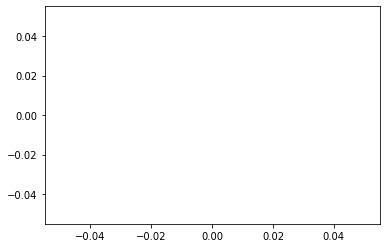

In [15]:

def main():
    #I choose a dataset with two well separated part
    # x=np.random.rand(10,3)
    # # print(x)
    # x=np.tile(x,(2,1))
    # # print(x)
    # x[:10]*=0.1
    # # print(x)
    # print(x.shape)
    dataset = load_from_csv('Datasets/mnist_test.csv')
    x = dataset.iloc[:, 1:].values
    print(x.shape)
    x = x[:20]
    print(x.shape)
    color=['blue']*10+['red']*10

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(x[:,0],x[:,1],x[:,2],color=color)
    # plt.show()

    table_p=compute_p(x)

    #Probably not the right way to initialize the new space y
    y=x.dot(np.random.rand(x.shape[1],2))
    print(y)
    y-=np.mean(y)
    print(y)
    y/=np.std(y)
    print(y)
    table_q=compute_q(y)
    y=gradient_descent(table_p,table_q,y)
    print(y)

    plt.scatter(y[:,0],y[:,1],color=color)
    plt.show()

main()